In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np
import gc


2024-04-16 14:40:32.340155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 14:40:32.906428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pickle_file_path = './data/test_df.pickle'

with open(pickle_file_path, 'rb') as f:
    test_df = pickle.load(f)

pickle_file_path = './data/train_df.pickle'

with open(pickle_file_path, 'rb') as f:
    train_df = pickle.load(f)
    

study_name = '415_std_minmax_3'


In [3]:



mean_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']


selected_features_pickle_path = './data/selected_features_list.pickle'
with open(selected_features_pickle_path, 'rb') as f:
    FEATURE_COLS = pickle.load(f)

print(FEATURE_COLS)



['WORLDCLIM_BIO1_annual_mean_temperature', 'WORLDCLIM_BIO12_annual_precipitation', 'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month', 'WORLDCLIM_BIO15_precipitation_seasonality', 'WORLDCLIM_BIO4_temperature_seasonality', 'WORLDCLIM_BIO7_temperature_annual_range', 'SOIL_bdod_100.200cm_mean_0.01_deg', 'SOIL_bdod_15.30cm_mean_0.01_deg', 'SOIL_bdod_30.60cm_mean_0.01_deg', 'SOIL_bdod_60.100cm_mean_0.01_deg', 'SOIL_phh2o_0.5cm_mean_0.01_deg', 'SOIL_phh2o_100.200cm_mean_0.01_deg', 'SOIL_phh2o_15.30cm_mean_0.01_deg', 'SOIL_phh2o_30.60cm_mean_0.01_deg', 'SOIL_phh2o_5.15cm_mean_0.01_deg', 'SOIL_phh2o_60.100cm_mean_0.01_deg', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m12', 'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m12'

In [4]:
def plot_data(df, columns_names):
    plt.figure(figsize=(15, 3))

    # Setting up a grid of plots with 2 columns
    n_cols = 6
    n_rows = len(columns_names) // n_cols + (len(columns_names) % n_cols > 0)

    for i, col in enumerate(columns_names):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(df[col], bw_adjust=0.5, fill=False, color='blue')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()
    


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [6]:
import glob
import os

train_plot = train_df.copy()

directory_path = './NN_search'
pattern = f"{directory_path}/{study_name}_best_val_*.h5"

files = glob.glob(pattern)

max_r2_score = float('-inf')
best_model = None

# Käy läpi jokainen tiedosto ja etsi suurin r2_score_inv
for file in files:
    value = float(file.split('best_val')[1].split('_')[1])
    if value > max_r2_score:
        max_r2_score = value
        best_model = file


# Tulosta suurin löydetty r2_score_inv ja vastaava tiedosto
print(f"Best R2-score: {max_r2_score:.5f}")
if best_model:
    print(f"Best model: {best_model}")
else:
    print("No best model found")

best_log_transforms_name =  f'./NN_search/{study_name}_{max_r2_score:.5f}_best_log_transforms.pickle'
best_scalers_name = f'./NN_search/{study_name}_{max_r2_score:.5f}_best_scalers.pickle'


print(f'Opening log transforms from {best_log_transforms_name}')
with open(best_log_transforms_name, 'rb') as f:
    log_transforms = pickle.load(f)

print(f'Opening scalers from {best_scalers_name}')
with open(best_scalers_name, 'rb') as f:
    scaler_transforms = pickle.load(f)
        

Best R2-score: 0.29637
Best model: ./NN_search/415_std_minmax_3_best_val_0.29637_model.h5
Opening log transforms from ./NN_search/415_std_minmax_3_0.29637_best_log_transforms.pickle
Opening scalers from ./NN_search/415_std_minmax_3_0.29637_best_scalers.pickle


In [7]:
for target, log_base in log_transforms.items():
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_plot[target] = np.log(train_plot[target]) / np.log(log_base)
        
    elif log_base == 'sqrt':
        train_plot[target] = np.sqrt(train_plot[target])
        
    elif log_base == 'cbrt':
        train_plot[target] = np.cbrt(train_plot[target])
        
    else:
        train_plot[target] = train_plot[target]
        
for target, scaler in scaler_transforms.items():
    if scaler is not None:
        train_plot[target] = scaler.fit_transform(train_plot[target].values.reshape(-1, 1)).flatten()
        train_plot[target] = scaler.transform(train_plot[target].values.reshape(-1, 1)).flatten()

In [8]:
train_plot[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,-1.008245,-5.407330,1.283564,1.592122,0.000964,2.406494
std,0.400219,5.527331,1.060699,0.588147,0.005011,0.528763
min,-2.458946,-23.531824,0.182555,0.510491,-0.002741,0.869271
25%,-1.289843,-8.181016,0.553873,1.185120,-0.001895,2.057797
50%,-0.991666,-4.523266,0.822279,1.471036,-0.000904,2.416044
75%,-0.698873,-1.781055,1.721071,1.886668,0.001638,2.800118
max,-0.177903,7.190771,4.997564,3.677128,0.033027,3.566233


In [9]:
train_df[mean_columns].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


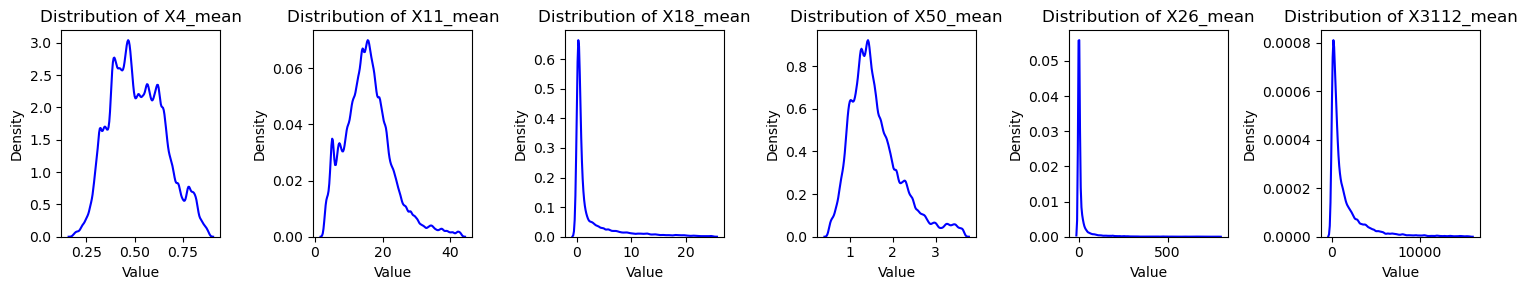

In [10]:
plot_data(train_df, mean_columns)

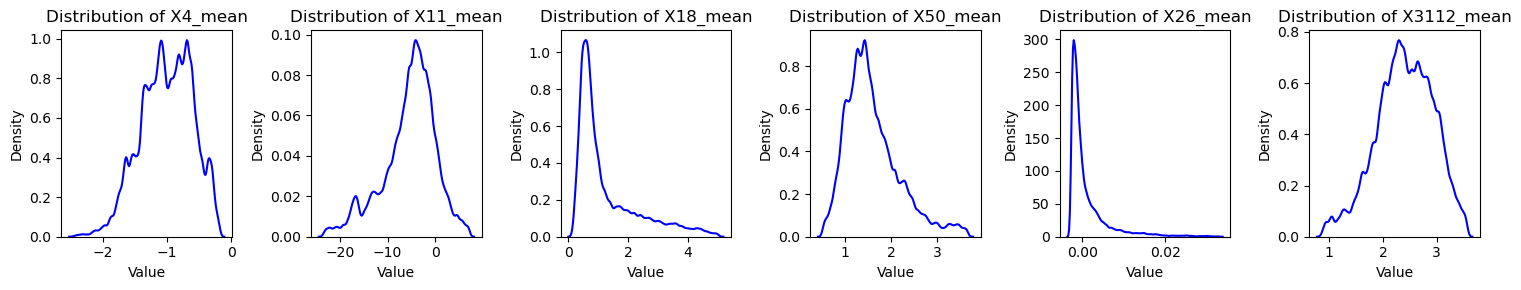

In [11]:
plot_data(train_plot, mean_columns)

In [12]:
train_df_original = train_df.copy()

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler

print(train_df['fold'].value_counts())

# scaler = StandardScaler() # TODO testaa robustscaler
scaler = RobustScaler()

sample_df = train_df.copy()
train_df = sample_df[sample_df.fold != 3]
valid_df = sample_df[sample_df.fold == 3]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")


train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)

scaler_tabufeatures_name = f'./NN_search/scaler_tabufeatures_{study_name}_train.pickle'
print(f"Saving scaler to {scaler_tabufeatures_name}")
with open(f'{scaler_tabufeatures_name}', 'wb') as f:
    pickle.dump(scaler, f)




fold
0.0    9834
2.0    9834
1.0    9834
4.0    9833
3.0    9833
Name: count, dtype: int64
# Num Train: 39335 | Num Valid: 9833
Saving scaler to ./NN_search/scaler_tabufeatures_415_std_minmax_3_train.pickle


/tmp/ipykernel_835064/540637523.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[FEATURE_COLS] = scaler.fit_transform(train_df[FEATURE_COLS].values)
/tmp/ipykernel_835064/540637523.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[FEATURE_COLS] = scaler.transform(valid_df[FEATURE_COLS].values)


In [14]:
X_train_tab = train_df[FEATURE_COLS].values
X_train_feat = np.stack(train_df['features'].values)
# y_train = train_df[mean_columns].values
y_train = train_df[mean_columns]

X_valid_tab = valid_df[FEATURE_COLS].values 
X_valid_feat = np.stack(valid_df['features'].values)
# y_valid = valid_df[mean_columns].values
y_valid = valid_df[mean_columns]



In [15]:


def r2_score_tf(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=0)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=0)), axis=0)
    r2 = 1 - ss_res/(ss_tot + tf.keras.backend.epsilon())
    r2 = tf.where(tf.math.is_nan(r2), tf.zeros_like(r2), r2)  # Korvaa NaN-arvot nollilla
    return tf.reduce_mean(tf.maximum(r2, 0.0))

custom_objects = {"r2_score_tf": r2_score_tf}


with open(f'./NN_search/scaler_tabufeatures_{study_name}_train.pickle', 'rb') as f:
    scaler_tabular = pickle.load(f)

print(f'Tabu features scaler: {scaler}')



best_model = tf.keras.models.load_model(f'{best_model}', custom_objects=custom_objects)

test_df_copy = test_df.copy()

test_df_copy[FEATURE_COLS] = scaler_tabular.transform(test_df_copy[FEATURE_COLS].values)

submission_df = test_df_copy[['id']].copy()

X_test_tab = test_df_copy[FEATURE_COLS].values
X_test_feat = np.stack(test_df_copy['features'].values) 

tf.keras.backend.clear_session()
gc.collect()

predictions = best_model.predict([X_test_feat, X_test_tab])

print(log_transforms)
print(scaler_transforms)

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        predictions[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target: : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        predictions[:, i] = np.power(log_base, predictions[:, i])
    elif log_base == 'sqrt':
        predictions[:, i] = np.square(predictions[:, i])
    elif log_base == 'cbrt':
        predictions[:, i] = np.power(predictions[:, i], 3)





Tabu features scaler: RobustScaler()


2024-04-16 14:40:38.739076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 14:40:38.763855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 14:40:38.763958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 14:40:38.769061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 14:40:38.769151: I tensorflow/compile

 55/205 [=======>......................] - ETA: 0s

2024-04-16 14:40:40.224063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


205/205 [==============================] - 1s 3ms/step
{'X4_mean': 2, 'X11_mean': 15, 'X18_mean': 'sqrt', 'X50_mean': None, 'X26_mean': 'sqrt', 'X3112_mean': 15}
{'X4_mean': None, 'X11_mean': StandardScaler(), 'X18_mean': None, 'X50_mean': None, 'X26_mean': MinMaxScaler(), 'X3112_mean': None}
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : StandardScaler()
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : MinMaxScaler()
Scaler transforming target : X3112_mean with scaler : None
Logpot transforming target: : X4_mean, log transform : 2
Logpot transforming target: : X11_mean, log transform : 15
Logpot transforming target: : X18_mean, log transform : sqrt
Logpot transforming target: : X50_mean, log transform : None
Logpot transforming target: : X26_mean, log transform : sqrt
Logpot transforming target: : X3112_mean, 

In [16]:

target_columns = ['X4', 'X11', 'X18', 'X50', 'X26', 'X3112']

submission_df[target_columns] = predictions


In [17]:
results_training_name = './data/results_training.pickle'

if os.path.exists(results_training_name):
    results_training = pd.read_pickle(results_training_name)
else:
    columns = ['Train R2', 'Train MSE', 'Train MAE', 'Valid R2', 'Valid MSE', 'Valid MAE', 'Train preds Desc', 'Valid preds Desc', 'Test preds Desc' , 'Original data Desc' 'Kaggle R2', 'Scalers', 'Log/Pot transforms', 'NN Search space', 'Tabular scaler']
    results_training = pd.DataFrame(columns = columns)
    results_training.index.name = 'Study name'

if study_name not in results_training.index:    
    results_training.loc[study_name] = [None]*len(results_training.columns)


test_preds_desc = submission_df[target_columns].describe().to_json()
results_training.at[study_name, 'Test preds Desc'] = test_preds_desc 

original_data_desc = train_df_original[mean_columns].describe().to_json()
results_training.at[study_name, 'Original data Desc'] = original_data_desc


In [18]:
print(f'{str(log_transforms.items())}')
print(f'{str(scaler_transforms.items())}')
print(f'{str(scaler_tabular)}')

results_training.at[study_name, 'Scalers'] = f'{scaler_transforms}'
results_training.at[study_name, 'Log/Pot transforms'] = f'{str(log_transforms.items())}'
results_training.at[study_name, 'Tabular scaler'] = f'{scaler_tabular}'


dict_items([('X4_mean', 2), ('X11_mean', 15), ('X18_mean', 'sqrt'), ('X50_mean', None), ('X26_mean', 'sqrt'), ('X3112_mean', 15)])
dict_items([('X4_mean', None), ('X11_mean', StandardScaler()), ('X18_mean', None), ('X50_mean', None), ('X26_mean', MinMaxScaler()), ('X3112_mean', None)])
RobustScaler()


In [19]:
## JÄRKEVYYSKOKEILU TESTATAAN train dataan

import numpy as np
import tensorflow as tf
import optuna
from keras import regularizers, layers, optimizers, initializers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from datetime import timedelta
import time
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## TEST DATA TEST

tf.keras.backend.clear_session()
gc.collect()

train_pred = best_model.predict([X_train_feat, X_train_tab])

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        train_pred[:, i] = scaler.inverse_transform(train_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    print(f'Logpot transforming target : {target}, log transform : {log_transforms[target]}')
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        train_pred[:, i] = np.power(log_base, train_pred[:, i])
    elif log_base == 'sqrt':
        train_pred[:, i] = np.square(train_pred[:, i])
    elif log_base == 'cbrt':
        train_pred[:, i] = np.power(train_pred[:, i], 3)

R2_train = r2_score(y_train, train_pred)
MSE_train = mean_squared_error(y_train, train_pred)
MAE_train = mean_absolute_error(y_train, train_pred)

print(f'Train scores:\nR2 : {R2_train:.5f}, MSE : {MSE_train:.5f}, MAE : {MAE_train:.5f}')

results_training.at[study_name, 'Train R2'] = R2_train
results_training.at[study_name, 'Train MSE'] = MSE_train
results_training.at[study_name, 'Train MAE'] = MAE_train

trainining_preds_desc = pd.DataFrame(train_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name, 'Train preds Desc'] = trainining_preds_desc


2024-04-16 14:40:41.112485: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 402790400 exceeds 10% of free system memory.
2024-04-16 14:40:41.587171: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 402790400 exceeds 10% of free system memory.


1230/1230 [==============================] - 4s 3ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : StandardScaler()
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : MinMaxScaler()
Scaler transforming target : X3112_mean with scaler : None
Logpot transforming target : X4_mean, log transform : 2
Logpot transforming target : X11_mean, log transform : 15
Logpot transforming target : X18_mean, log transform : sqrt
Logpot transforming target : X50_mean, log transform : None
Logpot transforming target : X26_mean, log transform : sqrt
Logpot transforming target : X3112_mean, log transform : 15
Train scores:
R2 : 0.45756, MSE : 530662.22199, MAE : 161.21510


In [20]:

## VALIDATION DATA TEST

tf.keras.backend.clear_session()
gc.collect()

valid_pred = best_model.predict([X_valid_feat, X_valid_tab])

for i, target in enumerate(mean_columns):
    print(f'Scaler transforming target : {target} with scaler : {scaler_transforms[target]}')
    scaler = scaler_transforms[target]
    if scaler is not None:
        valid_pred[:, i] = scaler.inverse_transform(valid_pred[:, i].reshape(-1, 1)).flatten()


for i, target in enumerate(mean_columns):
    log_base = log_transforms[target]
    if log_base is not None and log_base != 'sqrt' and log_base != 'cbrt':
        valid_pred[:, i] = np.power(log_base, valid_pred[:, i])
    elif log_base == 'sqrt':
        valid_pred[:, i] = np.square(valid_pred[:, i])
    elif log_base == 'cbrt':
        valid_pred[:, i] = np.power(valid_pred[:, i], 3)

R2_valid = r2_score(y_valid, valid_pred)
MSE_valid = mean_squared_error(y_valid, valid_pred)
MAE_valid = mean_absolute_error(y_valid, valid_pred)

print(f'Valid scores:\nR2 : {R2_valid:.5f}, MSE : {MSE_valid:.5f}, MAE : {MAE_valid:.5f}')

results_training.at[study_name, 'Valid R2'] = R2_valid
results_training.at[study_name, 'Valid MSE'] = MSE_valid
results_training.at[study_name, 'Valid MAE'] = MAE_valid

valid_preds_desc = pd.DataFrame(valid_pred, columns = mean_columns).describe().to_json()
results_training.at[study_name, 'Valid preds Desc'] = valid_preds_desc

308/308 [==============================] - 1s 3ms/step
Scaler transforming target : X4_mean with scaler : None
Scaler transforming target : X11_mean with scaler : StandardScaler()
Scaler transforming target : X18_mean with scaler : None
Scaler transforming target : X50_mean with scaler : None
Scaler transforming target : X26_mean with scaler : MinMaxScaler()
Scaler transforming target : X3112_mean with scaler : None
Valid scores:
R2 : 0.29639, MSE : 621141.37311, MAE : 179.38716


In [21]:
logpot = results_training['Log/Pot transforms'].to_list()[0]


In [22]:
submission_df.head()

,id,X4,X11,X18,X50,X26,X3112
0,201238668,0.588798,13.214594,0.945523,1.366019,2.376048,211.602966
1,202310319,0.426107,18.838236,0.551976,1.388117,2.979589,494.249237
2,202604412,0.594788,10.930473,3.647450,1.819988,26.800343,1171.653564
3,201353439,0.463053,22.685799,0.299112,1.130061,1.510535,537.730713
4,195351745,0.516828,8.950850,0.147999,1.633770,0.031976,159.626083


In [23]:
print(submission_df.info())

submission_df.to_csv('./data/submission.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6545 entries, 0 to 6544
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      6545 non-null   int64  
 1   X4      6545 non-null   float32
 2   X11     6545 non-null   float32
 3   X18     6545 non-null   float32
 4   X50     6545 non-null   float32
 5   X26     6545 non-null   float32
 6   X3112   6545 non-null   float32
dtypes: float32(6), int64(1)
memory usage: 204.7 KB
None


In [24]:
Kaggle = None
results_training.at[study_name, 'Kaggle R2'] = Kaggle

for index, row in results_training.iterrows():
    print(f"Study Name: {index}")
    print(f'Kaggle R2: {row["Kaggle R2"]}')
    print(f"Train R2: {row['Train R2']}, Train MSE: {row['Train MSE']}, Train MAE : {row['Train MAE']}")
    print(f'Valid R2: {row["Valid R2"]}, Valid MSE: {row["Valid MSE"]}, Valid MAE: {row["Valid MAE"]}')
    print("-" * 50)
    print("Train preds Description:")
    display(pd.read_json(row['Train preds Desc']))
    print("Valid preds Description:")
    display(pd.read_json(row['Valid preds Desc']))
    print("Test preds Description:")
    display(pd.read_json(row['Test preds Desc']))
    print("Original data Description:")
    display(pd.read_json(row['Original data Desc']))
    

Study Name: 415_std_minmax_3
Kaggle R2: 0.2637
Train R2: 0.4575555647014293, Train MSE: 530662.2219949623, Train MAE : 161.21509662684085
Valid R2: 0.2963913641141514, Valid MSE: 621141.3731077696, Valid MAE: 179.38716170893187
--------------------------------------------------
Train preds Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,39335.000000,39335.000000,39335.000000,39335.000000,39335.000000,39335.000000
mean,0.524935,15.175647,2.907077,1.577247,20.087002,1335.188843
std,0.090243,4.775221,3.892179,0.365625,29.969755,1451.022217
min,0.334217,1.294550,0.036071,0.696703,0.000003,23.787121
25%,0.451879,12.755989,0.543939,1.337960,2.722636,394.784378
50%,0.507786,15.685817,0.973252,1.519959,6.171327,719.660461
75%,0.580674,18.118701,3.743307,1.724934,22.676159,1796.857605
max,1.027736,41.875420,40.147511,4.598495,306.069122,25982.849609


Valid preds Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000
mean,0.524130,15.094471,2.809706,1.576137,19.662107,1313.677979
std,0.086654,4.601624,3.549353,0.335762,28.107418,1382.437012
min,0.350423,1.709008,0.072423,0.774004,0.000015,26.850983
25%,0.452812,12.710351,0.555831,1.353272,2.767128,399.908051
50%,0.509988,15.580159,1.011319,1.534443,6.302506,728.482971
75%,0.578308,17.865107,3.857534,1.727614,23.146275,1769.856079
max,0.995505,39.068314,25.127493,4.480061,191.134338,12023.468750


Test preds Description:


,X4,X11,X18,X50,X26,X3112
count,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,0.520005,15.406152,2.793571,1.546832,18.475735,1250.304321
std,0.088047,4.898564,3.662536,0.338429,27.245813,1319.900635
min,0.356471,2.133878,0.065923,0.808355,0.000066,34.709415
25%,0.447470,12.708324,0.528840,1.312727,2.605151,385.172791
50%,0.503236,15.801558,0.947458,1.496752,5.813790,694.925537
75%,0.577838,18.457777,3.692252,1.706108,21.267752,1656.937378
max,0.934631,34.311958,30.790764,3.765429,239.018616,12611.203125


Original data Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


Study Name: 415_yo_std_minmax_power_3
Kaggle R2: 0.24457
Train R2: 0.352408360144764, Train MSE: 552689.3665836855, Train MAE : 163.56217774095833
Valid R2: 0.28511200589393765, Valid MSE: 616214.223820004, Valid MAE: 176.3757629853271
--------------------------------------------------
Train preds Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,39335.000000,39335.000000,39335.000000,39335.000000,39335.000000,39335.000000
mean,0.507982,16.498510,2.617432,1.546497,10.735717,1260.284180
std,0.069902,4.553965,3.606764,0.292448,23.911604,1419.847778
min,0.360479,1.800606,0.022927,0.812067,0.001309,20.025927
25%,0.450467,14.173867,0.348854,1.345498,0.772863,338.337082
50%,0.497913,17.089434,0.699954,1.510525,1.807302,633.011658
75%,0.555159,19.456038,3.639151,1.697867,7.733716,1706.182617
max,0.791959,33.174526,25.511585,3.057632,631.634460,14732.823242


Valid preds Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000,9833.000000
mean,0.508048,16.444685,2.592391,1.549274,10.396053,1243.645752
std,0.069054,4.489894,3.523186,0.286420,22.300793,1394.584106
min,0.379362,0.711578,0.046944,0.822063,0.004695,24.872528
25%,0.451043,14.091741,0.347357,1.357903,0.782752,341.039520
50%,0.499660,17.052368,0.705162,1.514262,1.841441,630.896179
75%,0.555028,19.326069,3.696883,1.697292,7.602113,1657.728760
max,0.783214,33.671234,22.909157,2.892230,369.553864,11824.161133


Test preds Description:


,X4,X11,X18,X50,X26,X3112
count,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,0.504668,16.702158,2.542959,1.526976,9.657392,1174.467651
std,0.070202,4.792036,3.518245,0.293156,21.783352,1300.314575
min,0.384270,1.949246,0.021815,0.893662,0.006111,24.527538
25%,0.444871,14.057751,0.331434,1.320035,0.724784,336.110779
50%,0.493059,17.284590,0.657099,1.489651,1.701115,619.823120
75%,0.553610,19.854639,3.539192,1.685199,6.949891,1569.350220
max,0.789628,31.138544,21.439247,2.819807,531.860962,11038.069336


Original data Description:


,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000,49168.000000
mean,0.516058,15.752458,2.772597,1.592122,24.176388,1598.763010
std,0.138489,6.961194,4.549765,0.588147,72.898061,2271.015359
min,0.181879,2.836897,0.033326,0.510491,0.005874,10.527904
25%,0.408995,11.060960,0.306775,1.185120,0.544728,263.122005
50%,0.502897,15.296873,0.676143,1.471036,2.289064,694.205681
75%,0.616053,19.505972,2.962085,1.886668,12.249738,1964.239682
max,0.883987,43.206557,24.975647,3.677128,785.944393,15639.231100


In [25]:
with open(results_training_name, 'wb') as f:
    results_training.to_pickle(f)

In [26]:
results_training.head(100)

,Train R2,Train MSE,Train MAE,Valid R2,Valid MSE,Valid MAE,Train preds Desc,Valid preds Desc,Test preds Desc,Kaggle R2,Original data Desc,Scalers,Log/Pot transforms,Tabular scaler
Study name,,,,,,,,,,,,,,
415_std_minmax_3,0.457556,530662.221995,161.215097,0.296391,621141.373108,179.387162,"{""X4_mean"":{""count"":39335.0,""mean"":0.524934768...","{""X4_mean"":{""count"":9833.0,""mean"":0.5241298079...","{""X4"":{""count"":6545.0,""mean"":0.5200051069,""std...",0.2637,"{""X4_mean"":{""count"":49168.0,""mean"":0.516057513...","{'X4_mean': None, 'X11_mean': StandardScaler()...","dict_items([('X4_mean', 2), ('X11_mean', 15), ...",RobustScaler()
415_yo_std_minmax_power_3,0.352408,552689.366584,163.562178,0.285112,616214.22382,176.375763,"{""X4_mean"":{""count"":39335.0,""mean"":0.507982015...","{""X4_mean"":{""count"":9833.0,""mean"":0.5080478191...","{""X4"":{""count"":6545.0,""mean"":0.504668355,""std""...",0.24457,"{""X4_mean"":{""count"":49168.0,""mean"":0.516057513...","{'X4_mean': MinMaxScaler(), 'X11_mean': PowerT...","dict_items([('X4_mean', 'cbrt'), ('X11_mean', ...",RobustScaler()
